Tensorflow Keras 기반 FT-Transformer 활용

In [3]:
'''
pip install tabtransformertf
pip install tensorflow-addons
pip install category_encoders
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow_addons as tfa
from tabtransformertf.utils.preprocessing import df_to_dataset, build_categorical_prep
from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
from scipy.stats import skew
import gc
import time
from tqdm import tqdm
from preprocessing import ct_df_ver05, ct_df_ver0
from lossfunction import rmse, mse, mae, mape, r_squared, adjusted_r_squared
import torch
from IPython.display import clear_output
clear_output()


In [4]:
print(ct_df_ver0.shape)

(3924, 58)


In [5]:
# 숫자형, 범주형 피쳐 리스트 생성
categorical_list=[]
numerical_list=[]
target ='WAITTIME'

for i in ct_df_ver0.columns :
  if ct_df_ver0[i].dtypes == 'O' :
    categorical_list.append(i)
  else :
    numerical_list.append(i)

numerical_list.remove('WAITTIME')
feature_list = categorical_list + numerical_list

print("categorical_list {}:".format(len(categorical_list)), categorical_list)
print("numerical_list {}:".format(len(numerical_list)), numerical_list)
print("feature_list {}:".format(len(feature_list)), feature_list)

categorical_list 15: ['DR', 'PROCESS_ID', 'PART_ID', 'LOTTYPE', 'HOLD_FLAG', 'FLOORID', 'LOT_PURPOSE', 'ROOM', 'PROCESS_GROUP', 'LAYER_TITLE', 'LAYER_GROUP', 'BLOCK_GROUP', 'EQPTYPE', 'BATCH', 'SHIFT_TYPE']
numerical_list 42: ['QTY', 'GRADE', 'COMPLETE_RATE', 'DUE_DATE', 'WIPTURN', 'MOVE_0', 'EQP_WORKLOAD_0', 'MOVE_1', 'EQP_WORKLOAD_1', 'MOVE_2', 'EQP_WORKLOAD_2', 'Q_E', 'Q_P', 'L_E', 'L_P', 'Q_H', 'Q_R', 'Q_W', 'L_H', 'L_R', 'L_W', 'Q_2', 'Q_3', 'Q_4', 'Q_5', 'Q_7', 'Q_8', 'Q_10', 'L_2', 'L_3', 'L_4', 'L_5', 'L_7', 'L_8', 'L_10', 'WIP_WAITTIME', 'WIP_PRODUCT_NUM', 'PROCESSTIME', 'PRC_WAIT_MIN', 'PRC_WAIT_MAX', 'PRC_WAIT_MEDIAN', 'PRC_WAIT_STD']
feature_list 57: ['DR', 'PROCESS_ID', 'PART_ID', 'LOTTYPE', 'HOLD_FLAG', 'FLOORID', 'LOT_PURPOSE', 'ROOM', 'PROCESS_GROUP', 'LAYER_TITLE', 'LAYER_GROUP', 'BLOCK_GROUP', 'EQPTYPE', 'BATCH', 'SHIFT_TYPE', 'QTY', 'GRADE', 'COMPLETE_RATE', 'DUE_DATE', 'WIPTURN', 'MOVE_0', 'EQP_WORKLOAD_0', 'MOVE_1', 'EQP_WORKLOAD_1', 'MOVE_2', 'EQP_WORKLOAD_2', 'Q_

In [6]:
scaler = StandardScaler()
scaler.fit(ct_df_ver0[numerical_list])  # +[target]
ct_df_ver0[numerical_list] = scaler.transform(ct_df_ver0[numerical_list])

In [7]:
ct_df_ver0.head(3)

,DR,PROCESS_ID,PART_ID,LOTTYPE,QTY,HOLD_FLAG,FLOORID,GRADE,COMPLETE_RATE,LOT_PURPOSE,DUE_DATE,WIPTURN,ROOM,PROCESS_GROUP,LAYER_TITLE,LAYER_GROUP,BLOCK_GROUP,EQPTYPE,MOVE_0,EQP_WORKLOAD_0,MOVE_1,EQP_WORKLOAD_1,MOVE_2,EQP_WORKLOAD_2,BATCH,Q_E,Q_P,L_E,L_P,Q_H,Q_R,Q_W,L_H,L_R,L_W,Q_2,Q_3,Q_4,Q_5,Q_7,Q_8,Q_10,L_2,L_3,L_4,L_5,L_7,L_8,L_10,WIP_WAITTIME,WIP_PRODUCT_NUM,SHIFT_TYPE,PROCESSTIME,PRC_WAIT_MIN,PRC_WAIT_MAX,PRC_WAIT_MEDIAN,PRC_WAIT_STD,WAITTIME
0,N4,BU,5P9865A02,PT,-1.577962,Y,S3,0.736054,0.527445,J,1.099325,-0.856079,PH,COATER_HSOH,L1,LG61,PU6,PARCCO,1.276886,-0.494027,1.641524,-0.474995,1.220223,-0.484387,N,0.241002,0.161233,1.593954,0.475556,0.647401,0.005643,-0.050758,1.813664,-0.118112,0.574254,-0.053185,0.038477,0.643172,0.004940,-0.072815,-0.229220,-0.165141,1.118177,1.043080,1.195202,0.53023,0.643033,0.821861,-0.168234,0.386017,1.885220,WG,-0.863148,-0.593284,1.440316,-0.367086,-0.164851,107.33
1,N4,BU,5P9865A02,PT,0.599387,Y,S3,-1.758140,1.433237,1,-1.519375,1.092171,PH,COATER_HSOH,D10,LG63,PU6,PARCCO,1.276886,-0.494027,1.641524,-0.474995,1.220223,-0.484387,N,0.308738,0.159075,1.552096,0.338404,0.875353,-0.288893,-0.007226,1.781939,-0.247729,0.455475,-0.397288,0.198991,0.557371,-0.093363,-0.050893,-0.075599,-0.165141,-0.416798,1.002843,0.944760,0.53023,0.896398,0.974658,-0.168234,0.456194,1.708192,WS,-0.824691,-0.593284,1.440316,-0.367086,-0.164851,273.13
2,N5,LJ,FK05M2X01,PP,0.599387,Y,S3,0.736054,1.055824,1,-1.157215,0.184286,PH,COATER_HSOH,D5,LG63,PU6,PARCCO,1.276886,-0.494027,1.641524,-0.474995,1.220223,-0.484387,N,0.308738,0.159075,1.552096,0.338404,0.875353,-0.288893,-0.007226,1.781939,-0.247729,0.455475,-0.397288,0.198991,0.557371,-0.093363,-0.050893,-0.075599,-0.165141,-0.416798,1.002843,0.944760,0.53023,0.896398,0.974658,-0.168234,0.456194,1.708192,WS,-0.786599,-0.481096,-0.401405,-0.364179,-0.700004,247.97


In [8]:
train_df, test_df = train_test_split(ct_df_ver0, test_size=0.2, random_state=11)
train_data, val_data = train_test_split(train_df, test_size=0.2, shuffle=True, random_state=11)
print(train_data.shape, val_data.shape, test_df.shape)

(2511, 58) (628, 58) (785, 58)


In [9]:
# Transform to TF "dataset"
train_dataset = df_to_dataset(train_data[feature_list+[target]], target, shuffle=True, batch_size=128)
val_dataset = df_to_dataset(val_data[feature_list+[target]], target, shuffle=True, batch_size=128)

In [10]:
category_prep_layers = build_categorical_prep(train_data, categorical_list)

100%|██████████| 15/15 [00:00<00:00, 261.52it/s]


In [11]:
# FT-Transformer model

ft_linear_encoder = FTTransformerEncoder(
    numerical_features=numerical_list,  # list of numeric features
    categorical_features=categorical_list,  # list of categorical features
    numerical_data=train_df[numerical_list].values,
    categorical_data=train_df[categorical_list].values,
    y = None,
    numerical_embedding_type='linear',
    embedding_dim=32,
    depth=3,
    heads=6,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass the encoder to the model
ft_model = FTTransformer(
    encoder=ft_linear_encoder,  # Encoder from above
    out_dim=1,  # Number of outputs in final layer
    out_activation='relu',  # Activation function for final layer
)

In [12]:
# Hyper parameters

epochs = 10
lr = 0.001
weight_decay = 0.0001
optimizer = tfa.optimizers.AdamW(
        learning_rate=lr, weight_decay=weight_decay
    )

ft_model.compile(
    optimizer = optimizer,
    loss = tf.keras.losses.MeanSquaredError(),
    metrics= [tf.keras.metrics.RootMeanSquaredError()],
)


early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=10)

history = ft_model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)


Epoch 1/10
20/20 [==============================] - 12s 336ms/step - loss: 4788630.0000 - importances_loss: 2397804.0000 - output_loss: 2390826.2500 - importances_root_mean_squared_error: 1548.4844 - output_root_mean_squared_error: 1546.2297 - val_loss: 4888960.5000 - val_importances_loss: 2451654.0000 - val_output_loss: 2437306.2500 - val_importances_root_mean_squared_error: 1565.7759 - val_output_root_mean_squared_error: 1561.1875
Epoch 2/10
20/20 [==============================] - 5s 270ms/step - loss: 4779489.0000 - importances_loss: 2397803.7500 - output_loss: 2381685.0000 - importances_root_mean_squared_error: 1548.4843 - output_root_mean_squared_error: 1543.2709 - val_loss: 4883278.0000 - val_importances_loss: 2451654.0000 - val_output_loss: 2431623.7500 - val_importances_root_mean_squared_error: 1565.7761 - val_output_root_mean_squared_error: 1559.3665
Epoch 3/10
20/20 [==============================] - 5s 271ms/step - loss: 4774149.0000 - importances_loss: 2397803.7500 - outpu

In [13]:
history = history.history

In [14]:
fontsize_title = 25
fontsize_axis = 15

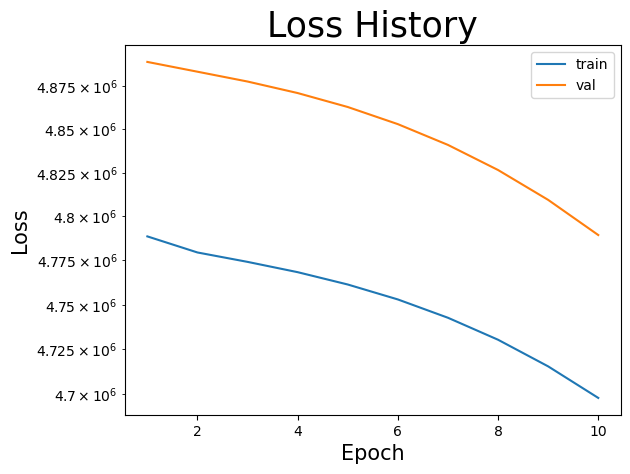

In [15]:
plt.plot(range(1, len(history['loss'])+1), history['loss'], label='train')
plt.plot(range(1, len(history['val_loss'])+1), history['val_loss'], label='val')
plt.yscale('log')
plt.title('Loss History', fontsize=fontsize_title)
plt.xlabel('Epoch', fontsize=fontsize_axis)
plt.ylabel('Loss', fontsize=fontsize_axis)
plt.legend()
plt.show()

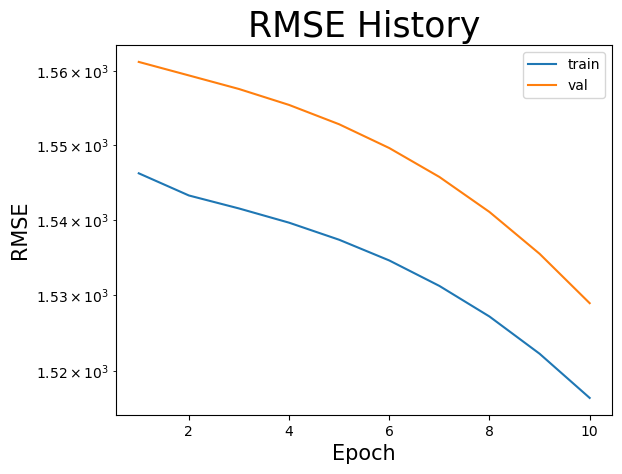

In [16]:
plt.plot(range(1, len(history['output_root_mean_squared_error'])+1), history['output_root_mean_squared_error'], label='train')
plt.plot(range(1, len(history['val_output_root_mean_squared_error'])+1), history['val_output_root_mean_squared_error'], label='val')
plt.yscale('log')
plt.title('RMSE History', fontsize=fontsize_title)
plt.xlabel('Epoch', fontsize=fontsize_axis)
plt.ylabel('RMSE', fontsize=fontsize_axis)
plt.legend()
plt.show()

5/5 [==============================] - 1s 99ms/step


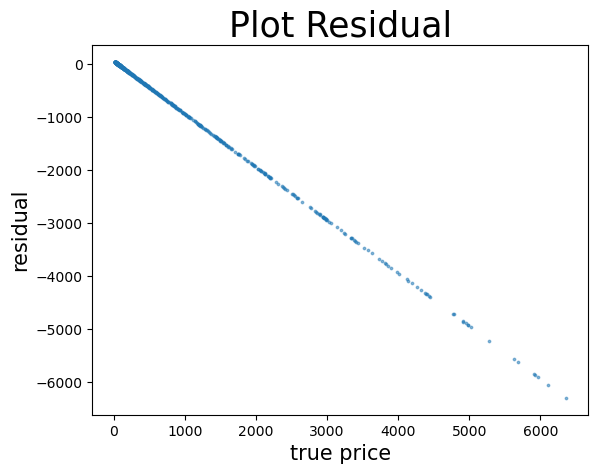

In [17]:
y_pred = ft_model.predict(val_dataset)['output'].reshape(-1)
y_true = val_data['WAITTIME'].values
residual = y_pred - y_true
plt.scatter(y_true, residual, s=3, alpha=0.5)
plt.title('Plot Residual', fontsize=fontsize_title)
plt.xlabel('true price', fontsize=fontsize_axis)
plt.ylabel('residual', fontsize=fontsize_axis)
plt.show()

In [18]:
test_df[numerical_list]= scaler.transform(test_df[numerical_list])
test_dataset = df_to_dataset(test_df, shuffle=False)

In [19]:
y_pred = ft_model.predict(test_dataset)['output'].reshape(-1)

2/2 [==============================] - 1s 212ms/step


In [20]:
y_pred

array([62.778316, 62.77824 , 62.778   , 62.778183, 62.778397, 62.778393,
       62.77834 , 62.778404, 62.778244, 62.778156, 62.778522, 62.778305,
       62.77841 , 62.778385, 62.778664, 62.778248, 62.778336, 62.77828 ,
       62.778397, 62.778423, 62.778206, 62.778282, 62.778397, 62.77842 ,
       62.778282, 62.77845 , 62.77784 , 62.778214, 62.77829 , 62.77813 ,
       62.77854 , 62.77813 , 62.778557, 62.778328, 62.77825 , 62.77738 ,
       62.778015, 62.7781  , 62.778183, 62.778255, 62.7786  , 62.778107,
       62.778275, 62.778183, 62.77796 , 62.778572, 62.77823 , 62.778023,
       62.77797 , 62.778152, 62.77772 , 62.778275, 62.77793 , 62.777657,
       62.77838 , 62.777985, 62.77773 , 62.77842 , 62.778374, 62.77851 ,
       62.778225, 62.777645, 62.777767, 62.777905, 62.77812 , 62.777603,
       62.778103, 62.778374, 62.778275, 62.778053, 62.778595, 62.77821 ,
       62.77818 , 62.77838 , 62.77801 , 62.77792 , 62.778374, 62.778397,
       62.778183, 62.777817, 62.778255, 62.778416, 

In [21]:
actual = test_df['WAITTIME'].reset_index(drop=True)

In [22]:
actual

0        27.62
1       444.42
2        28.05
3        29.58
4       879.70
        ...   
780     195.27
781    3534.43
782    1459.72
783    1716.13
784     612.83
Name: WAITTIME, Length: 785, dtype: float64

In [23]:
pred_df = pd.DataFrame(y_pred, columns=['pred'])
pred_df['actual'] = actual
pred_df.head(30)

,pred,actual
0,62.778316,27.62
1,62.778240,444.42
2,62.778000,28.05
3,62.778183,29.58
4,62.778397,879.70
5,62.778393,68.10
6,62.778339,216.90
7,62.778404,97.53
8,62.778244,28.85
9,62.778156,107.75


In [24]:
y_pred = np.log1p(y_pred)

In [25]:
actual = np.log1p(actual)

In [26]:
actual

0      3.354106
1      6.099018
2      3.369018
3      3.420346
4      6.780717
         ...   
780    5.279491
781    8.170590
782    7.286685
783    7.448410
784    6.419718
Name: WAITTIME, Length: 785, dtype: float64

In [27]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actual, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 5.031651506485552
